# Deep Learning for solving Argument Mining tasks

Argument mining task addressed:

- Argumentative fragment detection

## Loading the corpus

Decide-Madrid-2019: https://github.com/argrecsys/decide-madrid-2019-annotations

In [ ]:
# Mount Drive files
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd

def load_sst_data(path: str):
  data = pd.read_csv(path)
  return data

drive_path = "drive/My Drive/Datasets/dm-2019/"
dataset_home = drive_path + "data/dm-2019-annotated.csv"
dataset = load_sst_data(dataset_home)
dataset

,sent_id,sent_text,sent_label1,sent_label2,sent_label3
0,109-0-0,Limpieza de graffitis y remodelación de aluche,YES,CLAIM,NONE
1,109-0-0,Los vecinos de Aluche vemos día tras día como ...,YES,CLAIM,NONE
2,109-0-0,Los vecinos de Aluche vemos día tras día como ...,YES,CLAIM,NONE
3,109-0-1,"Graffitis y basura por todas partes, aceras ro...",YES,CLAIM,NONE
4,109-17276-0,No a los ruidos.,YES,CLAIM,NONE
...,...,...,...,...,...
3249,89-78258-1,Os recuerdo que España es el país de la OCDE d...,YES,PREMISE,EXPLANATION
3250,89-78258-2,La desigualdad en España avanza a un ritmo que...,YES,PREMISE,EXPLANATION
3251,89-78258-3,La pobreza y la exclusión en España han aument...,NO,SPAM,NONE
3252,89-78258-4,"Por otra lado, estamos a la espera de que nos ...",NO,SPAM,NONE


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(dataset, *['sent_label1'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(dataset, *['sent_label2'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(dataset, *['sent_label1', 'sent_label2'], **{})
chart

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def split_data(df, target_column, test_size=0.2, validation_size=0.1, random_state=None):

  # Split the data into a temporary train set and test/validation set
  train, temp = train_test_split(df, test_size=(test_size + validation_size), stratify=df[target_column], random_state=random_state)

  # Split the temp set into validation and test sets
  test, validation = train_test_split(temp, test_size=validation_size / (test_size + validation_size), stratify=temp[target_column], random_state=random_state)

  return train, validation, test

In [ ]:
label_column = "sent_label1"
t1_label_dict = {"NO": 0, "YES": 1}

t1_data = dataset[["sent_text", label_column]]
t1_data = t1_data.replace({label_column: label_dict})

training_set, validation_set, test_set = split_data(t1_data, target_column=label_column, test_size=0.1, validation_size=0.1, random_state=42)

Validation of stratified split:

In [ ]:
# Shuffle dataset
training_set = shuffle(training_set)
validation_set = shuffle(validation_set)
test_set = shuffle(test_set)

# Obtain text and label vectors
train_texts = training_set["sent_text"]
train_labels = training_set[label_column]

validation_texts = validation_set["sent_text"]
validation_labels = validation_set[label_column]

test_texts = test_set["sent_text"]
test_labels = test_set[label_column]

print("Training size: {}".format(len(training_set)))
print("Validation size: {}".format(len(validation_set)))
print("Test size: {}".format(len(test_set)))

Training size: 2603
Dev size: 326
Test size: 325


In [ ]:
print(f"Training classes:\n{train_labels.value_counts() / len(train_labels)}")

Training classes:
0    0.551287
1    0.448713
Name: sent_label1, dtype: float64


In [ ]:
print(f"Validation classes:\n{validation_labels.value_counts() / len(validation_labels)}")

Dev classes:
0    0.552147
1    0.447853
Name: sent_label1, dtype: float64


In [ ]:
print(f"Test classes:\n{test_labels.value_counts() / len(test_labels)}")

Test classes:
0    0.550769
1    0.449231
Name: sent_label1, dtype: float64


## Deep classifier - Simple fine tuning

### Installing and seting up the Transformers library

In [ ]:
import tensorflow as tf

## for replicability of results
tf.random.set_seed(2)

In [ ]:
# https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00


Once the transformers library is installed, we can use it directly just creating three object of two classes:

- The tokenizer class
- The model class

The contextualized model in Spanish that we are going to use is BETO: https://github.com/dccuchile/beto

- HuggingFace cased model: https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased
- HuggingFace uncased model: https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased

In [ ]:
# Creating a Bert-based model from a pre-trained HF model
from transformers import TFBertForSequenceClassification, BertTokenizer

hf_model_name = "dccuchile/bert-base-spanish-wwm-cased"
model = TFBertForSequenceClassification.from_pretrained(hf_model_name)
tokenizer = BertTokenizer.from_pretrained(hf_model_name)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next we will define two helper function to 1) extract features from the tokenizer (`convert_examples_to_features`) and 2) convert the features to `tf.data.Dataset` object class (`convert_features_to_tf_dataset`). `tf.data.Dataset` is a convinient API that helps managing and iterating in efficient way the input and output data of the model.  For more information you can check the API in tensorflow web page: https://www.tensorflow.org/api_docs/python/tf/data/Dataset.

In [ ]:
from transformers import InputFeatures

def convert_examples_to_features(texts, labels):
  labels = list(labels)
  batch_encoding = tokenizer.batch_encode_plus(texts, max_length=128, padding='longest')

  features = []
  for i in range(len(texts)):
    inputs = {k: batch_encoding[k][i] for k in batch_encoding}
    feature = InputFeatures(**inputs, label=labels[i])
    features.append(feature)

  for i, example in enumerate(texts[:5]):
    print("*** Example ***")
    print("text: %s" % (example))
    print("features: %s" % features[i])

  return features

def convert_features_to_tf_dataset(features):
  def gen():
    for ex in features:
      yield ({
          "input_ids": ex.input_ids,
          "attention_mask": ex.attention_mask,
          "token_type_ids": ex.token_type_ids
          }, ex.label)

  output_types = ({
      "input_ids": tf.int32,
      "attention_mask": tf.int32,
      "token_type_ids": tf.int32
      }, tf.int32)

  output_shapes = ({
      "input_ids": tf.TensorShape([None]),
      "attention_mask": tf.TensorShape([None]),
      "token_type_ids": tf.TensorShape([None])
      }, tf.TensorShape([]))

  dataset = tf.data.Dataset.from_generator(gen, output_types, output_shapes)
  return dataset

Model hyper-params:

In [ ]:
batch_size = 16
num_epochs = 3

Let's preprocess the training and development sets. Note that we use the `tf.data.Dataset` API to set the batch size to 16.

In [ ]:
train_features = convert_examples_to_features(train_texts, train_labels)
train_dataset = convert_features_to_tf_dataset(train_features)

validation_features = convert_examples_to_features(validation_texts, validation_labels)
validation_dataset = convert_features_to_tf_dataset(validation_features)

train_dataset = train_dataset.shuffle(100).batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

*** Example ***
text: El aceite de cocina lo puedes dejar en los puntos limpios que hay en cada barrio.
features: InputFeatures(input_ids=[4, 1162, 9536, 1008, 6765, 1114, 2331, 2496, 1036, 1065, 3596, 27132, 1038, 1423, 1036, 1781, 7283, 1009, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Fine-tune BETO as Sentence Classifier

In [ ]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=num_epochs)

Epoch 1/3
163/163 [==============================] - 184s 761ms/step - loss: 0.5528 - accuracy: 0.7153 - val_loss: 0.5025 - val_accuracy: 0.7362
Epoch 2/3
163/163 [==============================] - 114s 699ms/step - loss: 0.3564 - accuracy: 0.8440 - val_loss: 0.5515 - val_accuracy: 0.7699
Epoch 3/3
163/163 [==============================] - 112s 685ms/step - loss: 0.1481 - accuracy: 0.9428 - val_loss: 0.8667 - val_accuracy: 0.7423


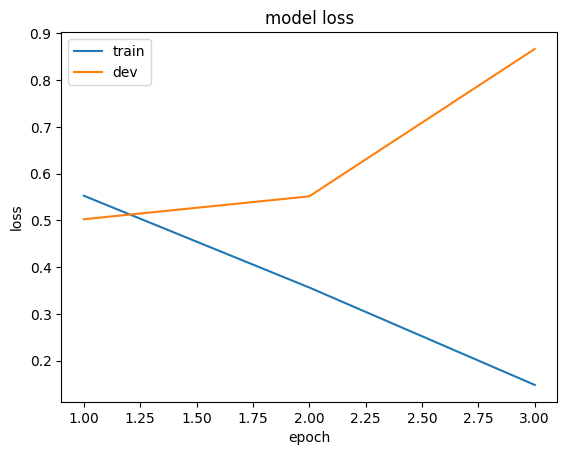

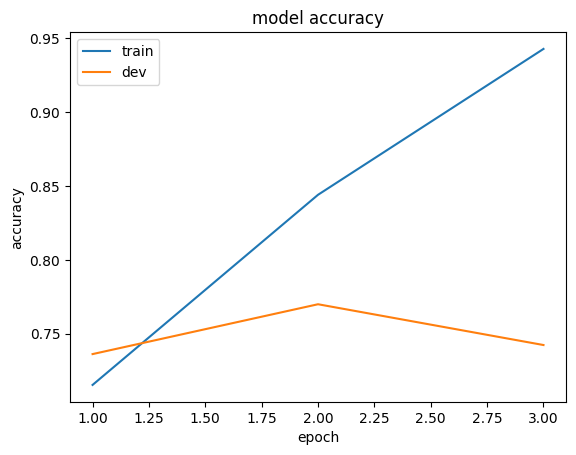

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# summarize history for accuracy
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

# summarize history for accuracy
plt.plot(epochs, history.history["accuracy"])
plt.plot(epochs, history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

### Testing out model

Once the model is fine-tuned for sentiment analysis we could evaluate it on the test set. In this we need to tokenized and convert to ids the input too.

In [ ]:
test_features = convert_examples_to_features(test_texts, test_labels)
test_dataset = convert_features_to_tf_dataset(test_features)

*** Example ***
text: No estoy del todo de acuerdo.
features: InputFeatures(input_ids=[4, 1125, 1764, 1072, 1397, 1008, 1708, 1009, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
test_dataset = test_dataset.batch(batch_size)
instances = list(test_dataset.take(1).as_numpy_iterator())
instances

[({'input_ids': array([[    4,  1125,  1764, ...,     1,     1,     1],
          [    4,  1278,  1400, ...,     1,     1,     1],
          [    4,  3712,  1084, ...,     1,     1,     1],
          ...,
          [    4,  1278,  1673, ...,     1,     1,     1],
          [    4, 11702, 30939, ...,     1,     1,     1],
          [    4,  1584,  1084, ...,     1,     1,     1]], dtype=int32),
   'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          ...,
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
   'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=int32)},
  array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1], dtype=int32))]

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

21/21 [==============================] - 4s 188ms/step - loss: 0.8990 - accuracy: 0.7415
Loss: 0.8990437388420105
Accuracy: 0.7415384650230408


### Serialize and save model

In [ ]:
# Serialize model to JSON
model_home = drive_path + "models/"
model_json = model.to_json()
with open(model_home + "am-t1-beto-model.json", "w") as json_file:
  json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights(model_home + "am-t1-beto-model.h5")

## Deep classifier - Robust fine tunning

Function to create a Bert-based model from a pre-trained HF model

In [ ]:
def build_model(hp):
  hf_model_name = "dccuchile/bert-base-spanish-wwm-cased"
  model = TFBertForSequenceClassification.from_pretrained(hf_model_name)

  # Adjustable hyperparameters
  hp_learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-4, sampling="log")
  hp_learning_rate = hp.Float("epsilon", min_value=1e-9, max_value=1e-7, sampling="log")
  hp_epochs = hp.Int("epochs", min_value=1, max_value=10)

  # Fixed hyperparameters
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

  optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, epsilon=hp_learning_rate, clipnorm=1.0)
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

  return model

Configure the random tuner

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.2 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory=drive_path + "results",
    project_name="bert_hyperparameter_tuning"
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Configure early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(train_dataset, validation_data=validation_dataset, epochs=num_epochs, callbacks=[stop_early])

Trial 10 Complete [00h 08m 13s]
val_accuracy: 0.7607361674308777

Best val_accuracy So Far: 0.7668711543083191
Total elapsed time: 01h 19m 30s


In [ ]:
# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]
best_model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Summary of the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters.values)

Best Hyperparameters:
{'learning_rate': 3.3976086027238197e-06, 'epochs': 2}


In [ ]:
# Evaluate the best model on the test dataset
loss, accuracy = best_model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

21/21 [==============================] - 8s 185ms/step - loss: 0.5259 - accuracy: 0.7323
Loss: 0.5259179472923279
Accuracy: 0.7323076725006104


---

You can check how much GPU/CPU you are using in your colab sessions.

In [ ]:
# Memory footprint support libraries/code
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# Only one GPU on Colab and isn't guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free:", humanize.naturalsize(psutil.virtual_memory().available), "I Proc size:", humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=ee667b1b608c5561fe092bc55798026d0359288c8cc857f3d1b99261e7e58e6c
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 2.4 GB I Proc size: 8.6 GB
GPU RAM Free: 6252MB | Used: 8849MB | Util  58% | Total 15360MB
